# Procesos estocásticos en tiempo continuo

El ajuste a datos reales se logra con reescalamiento y combinación de procesos simulados de Weiner.
Empiezo por simulación de procesos individuales.


# Movimiento Browniano

### Convenciones:
Matriz de d trayectorias de una serie de n tiempos será matriz d x n. 


Trayectoria==individuo, cada tiempo una variable

Simulación de browniano:
$$B_{t+1}=B_t+\sqrt{t} Z_t, \quad Z_t~N(0,1)$$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
import brownian_motion as bm

size dB:  10000 0.0001
var B:  0.00010386661643324374


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

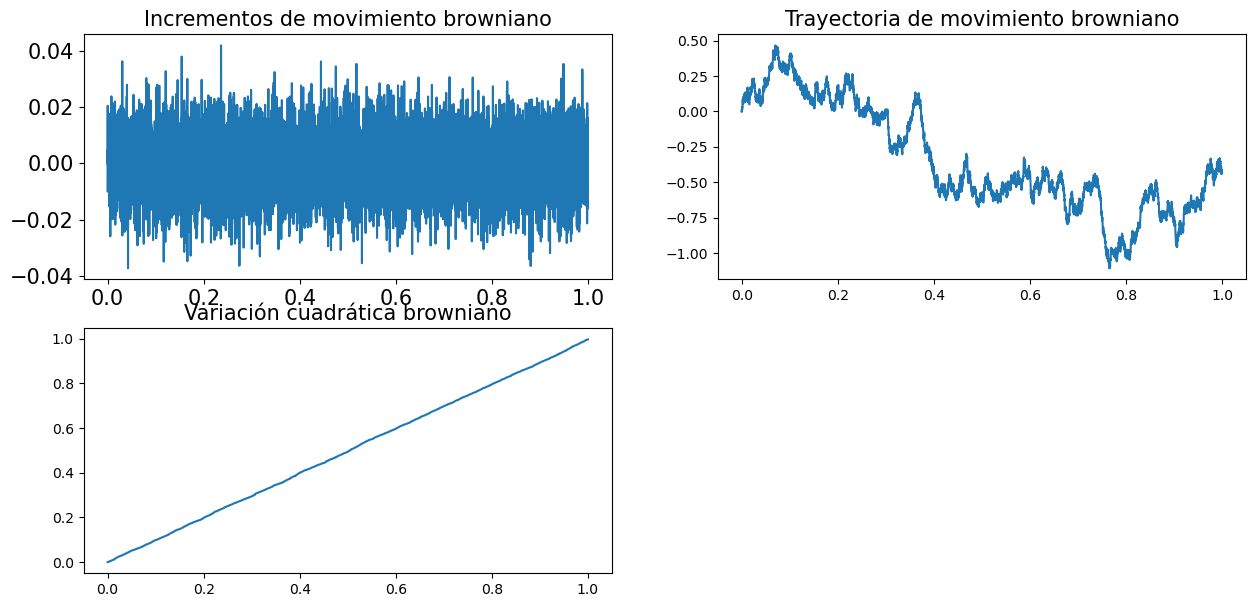

In [2]:
#simulación individual

T=1#Horizonte de tiempo
s=9999 # num de subintervalos
n=s+1
time=np.linspace(0,T,n)#Con n=s+1 puntos obtengo 0=t_0<...<t_n=T, n subintervalos
dt=T/n

dB=bm.get_dB(n,dt=dt)#,random_state=5)
print("size dB: ", dB.size,dt)
B=bm.get_B(n,dt=dt)#,random_state=5) 
print("var B: ",np.var(dB))

# dB = get_dB(1_000)

# B  = get_B(1_000)

fig = plt.figure(figsize=(15, 7))

title = "Incrementos de movimiento browniano"
plt.subplot(2, 2, 1)
plt.plot(time,dB.T) #basta plt.plot(dB.T) si el dt=1
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Trayectoria de movimiento browniano"
plt.subplot(2, 2, 2)
plt.plot(time, B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

title = "Variación cuadrática browniano"
plt.subplot(2, 2, 3)
plt.plot(time,bm.quadratic_variation(B).T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Simulación de matriz de trayectorias
(dxn). d trayectorias con n muestreos (n y dt dados)

(10000,) (10000,)


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

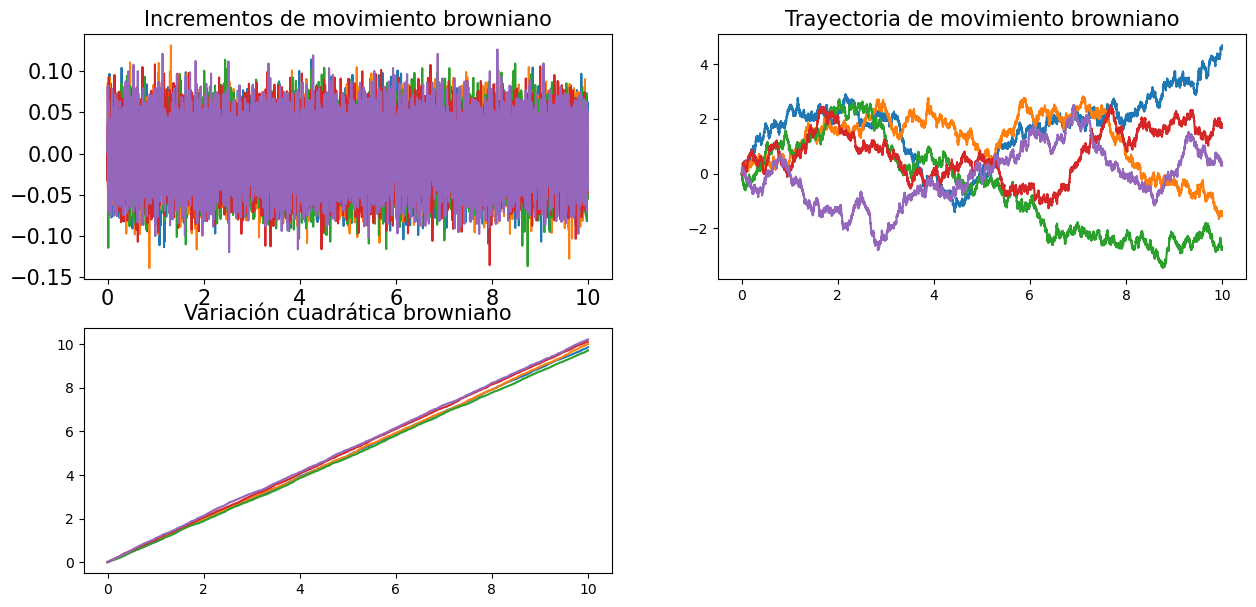

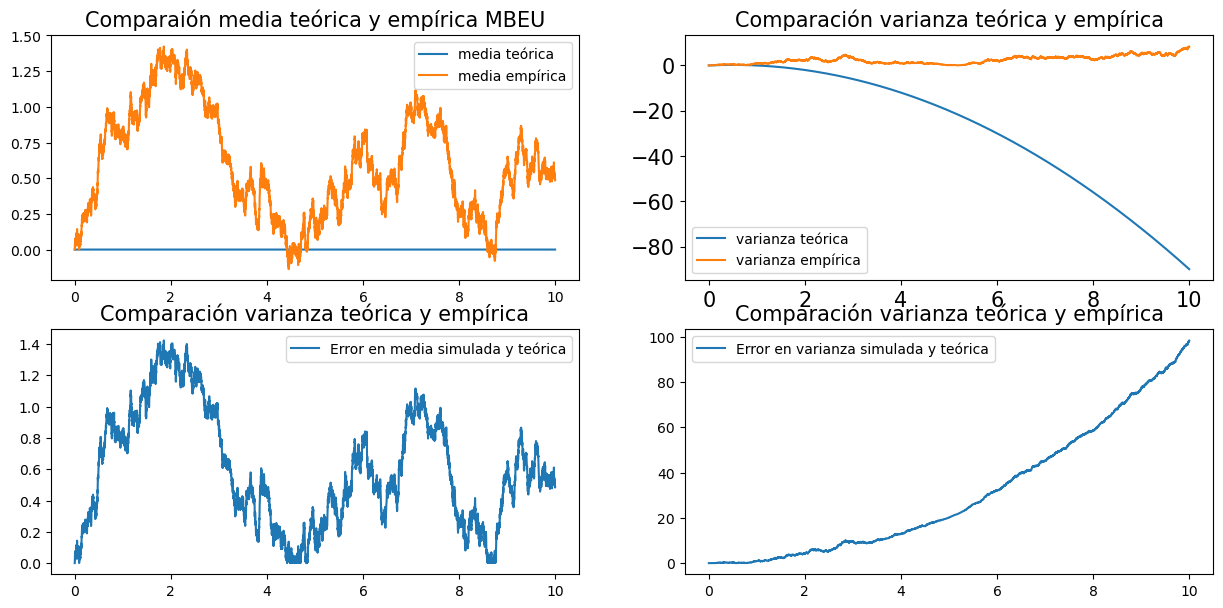

In [13]:
T=10
s=9_999
n=s+1
d=5
time=np.linspace(0,T,n)
dt=T/n

B=bm.get_B_matrix(n,d,dt)
dB=bm.dif_B(B)

fig = plt.figure(figsize=(15, 7))

title = "Incrementos de movimiento browniano"
plt.subplot(2, 2, 1)
plt.plot(time,dB.T) #basta plt.plot(dB.T) si el dt=1
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Trayectoria de movimiento browniano"
plt.subplot(2, 2, 2)
plt.plot(time, B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

title = "Variación cuadrática browniano"
plt.subplot(2, 2, 3)
plt.plot(time,bm.quadratic_variation(B).T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#Comparación teórica y simulada de media, varianzas y covarianzas



mu_hat_t,cov_hat_st=bm.empiric_mu_cov(B)
mu_teor,cov_teor=bm.mbeu_theoret_mu_cov(time)
mu_error=bm.error(mu_hat_t,mu_teor)

var_hat_t=np.diag(cov_hat_st)
var_teor_t=np.diag(cov_teor)
var_error=bm.error(var_hat_t,var_teor_t)

print(mu_hat_t.shape, var_hat_t.shape, )
#Plot
fig = plt.figure(figsize=(15, 7))
# paths
title = "Comparaión media teórica y empírica MBEU"
plt.subplot(2, 2, 1)
plt.plot(time, np.array([mu_teor,mu_hat_t]).T)
plt.legend(["media teórica","media empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#correlation
title = "Comparación varianza teórica y empírica"
plt.subplot(2, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array([var_teor_t,var_hat_t]).T)
plt.legend(["varianza teórica","varianza empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.subplot(2, 2, 3)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array(mu_error).T)
plt.legend(["Error en media simulada y teórica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplot(2, 2, 4)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array(var_error).T)
plt.legend(["Error en varianza simulada y teórica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


### Correlacionados y matriz de d trayectorias
$W_3$ correlacionado con $W_1$. Con la relación $$dW_3(t)=\rho dW_1(t)+\sqrt{1-\rho^2}dW_2(t)$$
Se tiene que $corr(W_1,W_3)=\rho$.

Usualmente necesitaré múltiplos procesos. El segundo proceso correlacionado por $\rho$ con el primero, el segundo correlacionado por $\rho$ con una elección aleatoria de los procesos ya generados. Simularé una matriz con cada columna como un proceso browniano. 

La matriz será (dxn). Con $\rho=0$ o None, tengo d trayectorias independientes.

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

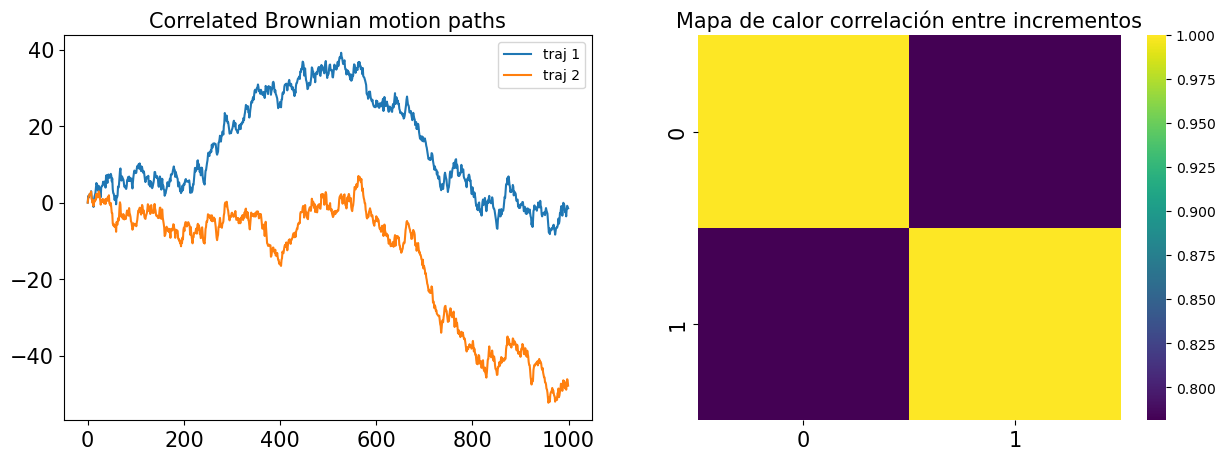

In [4]:
T = 1_000 
#dt =1 --> T=n
n_procs = 2
rho = 0.8

#En caso de usar dt
corr_Bs = bm.get_B_matrix(T, n_procs,rho=rho)
corr_dBs=bm.dif_B(corr_Bs)

#Plot
fig = plt.figure(figsize=(15, 5))
# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(corr_Bs.T)
plt.legend(["traj 1","traj 2"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Mapa de calor correlación entre incrementos"
plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
sns.heatmap(np.corrcoef(corr_dBs, rowvar=True), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# title = "Mapa de calor correlación entre trayectorias"
# plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
# plt.gca().set_title(title, fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)



## Medidas de error

In [6]:

print(np.linspace(0,n,n+1).shape)
    
    

###Medidas de error:
def mse(y:np.array,y_hat:np.array)->float:
    return np.mean(np.square(y-y_hat))

def mae(y:np.array,y_hat:np.array)->float:
    return np.mean(np.abs(y-y_hat))


(10002,)


# Movimientos asociados




###  Movimiento browniano bridge   


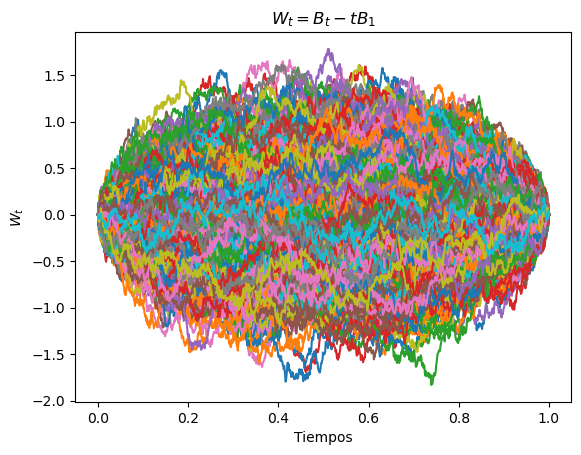

(1001,) (1001,)
Var:  0.0009973290669671457


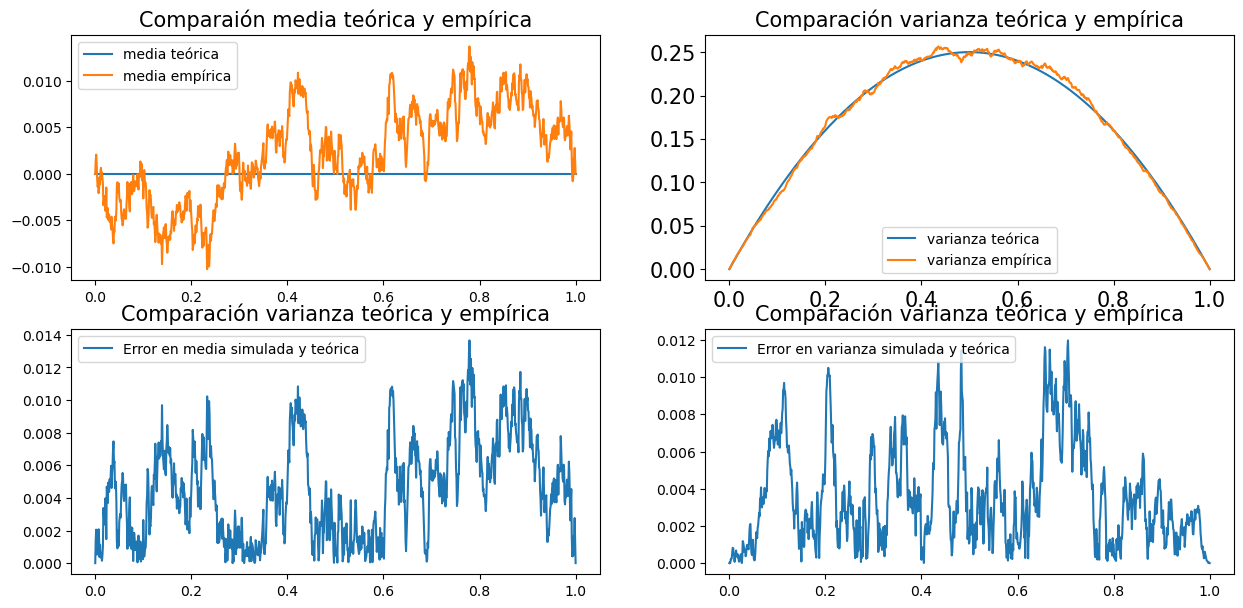

In [12]:
T=1
n=1000
dt=T/n
d=1000
time=np.linspace(0,1,n+1)
Bridge=bm.get_Bridge_matrix(n+1,d)
# Graficamos el movimiento browniano de Bridge
fig, ax = plt.subplots()
ax.plot(time,Bridge.T)
ax.set_title("$W_t = B_t -tB_1$")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show() 




#Medidas empíricas de centraldiad y dispersión:
#Media: (cada columna (Bridge[:,i]) es muestra de W_t para t=i*dt)
#Covarianza
    
x,y=time,time

mu_hat_t,cov_hat_st=bm.empiric_mu_cov(Bridge)
mu_teor,cov_teor=bm.bridge_theoret_mean_cov(time)
mu_error=bm.error(mu_hat_t,mu_teor)

var_hat_t=np.diag(cov_hat_st)
var_teor_t=np.diag(cov_teor)
var_error=bm.error(var_hat_t,var_teor_t)

print(mu_hat_t.shape, var_hat_t.shape, )
#Plot
fig = plt.figure(figsize=(15, 7))
# paths
title = "Comparaión media teórica y empírica"
plt.subplot(2, 2, 1)
plt.plot(time, np.array([mu_teor,mu_hat_t]).T)
plt.legend(["media teórica","media empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#correlation
title = "Comparación varianza teórica y empírica"
plt.subplot(2, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array([var_teor_t,var_hat_t]).T)
plt.legend(["varianza teórica","varianza empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.subplot(2, 2, 3)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array(mu_error).T)
plt.legend(["Error en media simulada y teórica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplot(2, 2, 4)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array(var_error).T)
plt.legend(["Error en varianza simulada y teórica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

dBridge=bm.dif_B(Bridge)
print("Var: ", np.var(dBridge)) #Verifico que la varianza de los incrementos es la adecuada.




### Ruido gaussiano blanco (coloreado?)

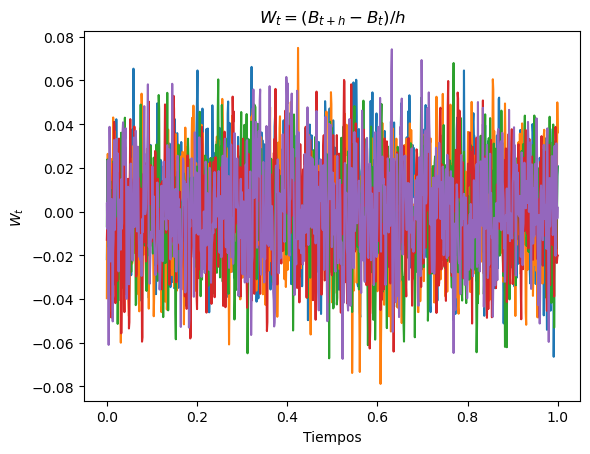

Size B: 50000
[[ 2.68009296e-04 -3.64933395e-05 -2.72483838e-05 ... -7.13053540e-05
  -3.18654274e-04 -2.11727729e-04]
 [-3.64933395e-05  1.63483567e-04  1.53340365e-05 ... -4.58170278e-05
   1.72806463e-04  1.52505465e-04]
 [-2.72483838e-05  1.53340365e-05  1.58339952e-04 ...  1.21698464e-04
   1.86824481e-04  1.34756647e-04]
 ...
 [-7.13053540e-05 -4.58170278e-05  1.21698464e-04 ...  1.89299708e-04
   2.18294532e-04  1.82635175e-04]
 [-3.18654274e-04  1.72806463e-04  1.86824481e-04 ...  2.18294532e-04
   6.96855136e-04  5.51684953e-04]
 [-2.11727729e-04  1.52505465e-04  1.34756647e-04 ...  1.82635175e-04
   5.51684953e-04  4.68194488e-04]]


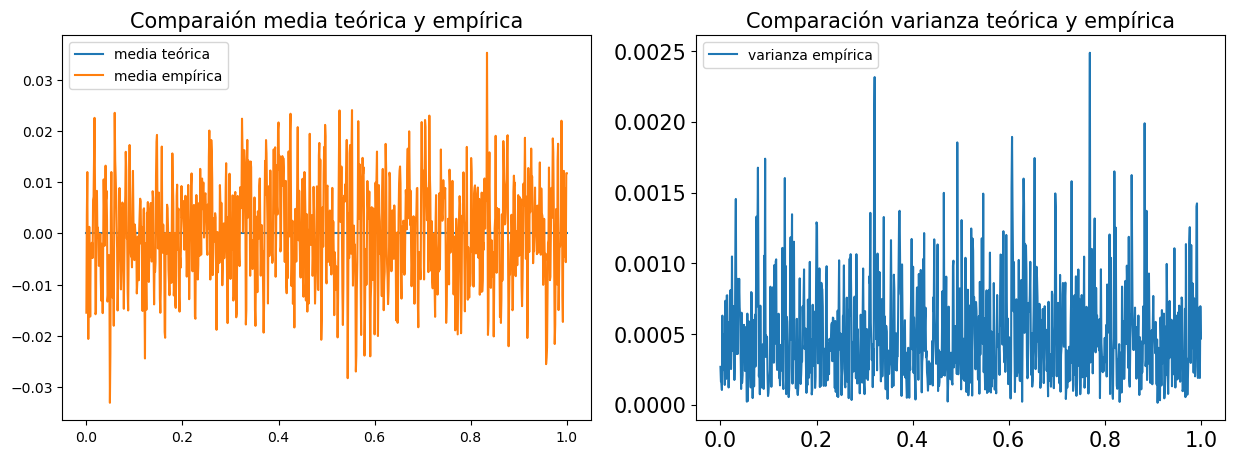

In [13]:
T=1
n=1000
dt=T/n
h=2
time=np.linspace(0,T,n+1)
Wn=bm.get_w_noise_matrix(n+1,5,h=h,dt=dt)


fig, ax = plt.subplots()
ax.plot(time,Wn.T)
ax.set_title("$W_t= (B_{t+h} -B_t)/h$")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

x,y=time,time
mu_theor,cov_theor=bm.w_noise_theoret_mu_cov(time,h=h)
mu_hat,cov_hat=bm.empiric_mu_cov(Wn)

var_hat=np.diag(cov_hat)
var_theor=np.diag(cov_theor)
print(f"Size B: {B.size}")

#Plot
fig = plt.figure(figsize=(15, 5))
# paths
title = "Comparaión media teórica y empírica"
plt.subplot(1, 2, 1)
plt.plot(time, np.array([mu_theor,mu_hat]).T)
plt.legend(["media teórica","media empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#correlation
title = "Comparación varianza teórica y empírica"
plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
plt.plot(time,np.array([var_theor,var_hat]).T)
plt.legend(["varianza teórica","varianza empírica"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

print(np.cov(Wn,rowvar=False))

### Browniano drift

In [ ]:
def get_Drift_matr(n:int,d:int,dt:float=1,random_state=None)->np.array:
    